# This notebook is concerned with handling Item Name

# Table of contents
- [Setup and load data](#setup-and-load-data)
- [Handling Item Names](#Handling-Item-Names)
    - [Basic normalization](#basic-normalization)
    - [Arabic lexicon](#string-tokens)
        - [Create](#create)
        - [Visualize lexicon frequency](#visualize-lexicon-frequency)
    - [Combine disjointed letters](#Combine-disjointed-letters)
        - [🚨 ***Trie and Viterbi Segment technique***](#Trie-and-Viterbi-segment-technique)
            - [A few tests](#a-few-tests)
        - [Rejoining the disjointed words](#Rejoining-the-disjointed-words)
    - [Analyze tokens](#Analyze-tokens)
    - [Reduced tokens](#reduced-tokens)
    - [Tokenize numerical](#Tokenize-numerical)
- [Train classifier](#Train-classifier)

- [Appendix](#Appendix)
    - [Tests](#tests)
        - [Trying out normalization techniques](#trying-out-normlization-techniques)
        - [Failed attempts by ChatGPT that took far too much time to test and had minimal improvements](#failed-attempts-by-chatgpt-that-took-far-too-much-time-to-test-and-had-minimal-improvements)

# Overview
## We'll be dealing with: 
- a mix of Arabic and English entries,
- item codes/numerical values,
- and lack of clear categorization.

## Approach:
1. Basic normalization
    - normalize letters and words
    - remove incomplete words
    - remove unnecessary chars/symbols
2. Break corpus into string tokens
3. Generate Arabic lexicon from whole words
    - Calculate unigram probability + Laplace Smoothing 
4. Combine disjointed letters into full words based on the lexicon
    - Trie (data structure) + Viterbi Segment technique (dynamic programming)
5. Analyze tokens in the data
6. Devise normalization → reduced tokens
7. Tokenize to numerical features
8. Train a classifier (or classify manually) into interpretable categories
9. Spend analysis-ready

# Setup and load data

In [338]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log

from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants: أ إ آ -> ا
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar,    # ة -> ه or keep ة depending on needs
    normalize_unicode            # Normalize Unicode strings into their canonically composed form
)
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize

import re
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

In [339]:
data_path = "../data/cleaned_num.xlsx"
df_original = pd.read_excel(data_path)
df = df_original.copy()

# For now we just care about Item Name
df = df[['Item Name']]

# Handling Item Names

## Basic normalization
Using CAMeL-Tools since it handles both Arabic and English texts

In [430]:
def normalize_text(text):
    text = normalize_unicode(text)
    text = dediac_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = text.strip()
    
    return text

df['Normalized'] = df['Item Name'].apply(normalize_text)

In [ ]:
# Let's see the results - yes I noticed some entries are split (like 1563) which really gave me a headache trying to solve lol
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed,Rejoined
301,فرشة سرايا 6.5 مم PB7 برونزالفاء (PCS),فرشه سرايا 6.5 مم PB7 برونزالفاء (PCS),,U n k n o w n
901,GATE BARIAR PANEL2,GATE BARIAR PANEL2,,U n k n o w n
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,ص ا ج ا س و د 10 م ل 8 * 4 م ت,صاجاسودملمت,صاج اسود لم


In [389]:
# Cell for lists of dimension/lists in Ar and En
# List 1: English unit tokens (lowercase; include singular/plural + common abbrevs)
UNIT_TOKENS_EN = {
    "x",
    # length
    "mm","millimeter","millimeters","millimetre","millimetres",
    "cm","centimeter","centimeters","centimetre","centimetres",
    "m","meter","meters","metre","metres",
    "km","kilometer","kilometers","kilometre","kilometres",
    "in","inch","inches",
    "ft","foot","feet",
    "yd","yard","yards",
    "mi","mile","miles",
    # mass
    "g","gram","grams","gramme","grammes",
    "mg","milligram","milligrams","milligramme","milligrammes",
    "kg","kilogram","kilograms","kilogramme","kilogrammes",
    "t","ton","tons","tonne","tonnes",
    "oz","ounce","ounces",
    "lb","lbs","pound","pounds","st","stone","stones",
    # volume
    "l","liter","liters","litre","litres",
    "ml","milliliter","milliliters","millilitre","millilitres",
    "cl","centiliter","centiliters","centilitre","centilitres",
    "dl","deciliter","deciliters","decilitre","decilitres",
    "cc"
}

# List 2: Arabic unit tokens (normalized, no spaces)
UNIT_TOKENS_AR = {
    # length
    "مم","ملم","مليمتر","مليمترات","ملليمتر","ملليمترات",
    "سم","سنتمتر","سنتيمتر","سنتيمترات","سنتمترات",
    "م","متر","أمتار",
    "كم","كلم","كيلومتر","كيلومترات",
    "إنش","انش","بوصة","بوصات",
    "قدم","أقدام",
    "ياردة","ياردات",
    "ميل","أميال",
    # mass
    "غ","جم","جرام","جرامات","غرام","غرامات",
    "ملغ","مغ","مجم","ميليغرام","ميليجرام","ميليغرامات","ميليجرامات","مليغرام","مليجرام",
    "كغ","كجم","كيلوغرام","كيلوجرام","كيلوغرامات","كيلوجرامات","كيلو",
    "طن","أطنان",
    "أونصة","أونصات","اوقية","أوقية","أوقيات",
    "رطل","أرطال",
    # volume
    "لتر","لترات",
    "مل","ميليلتر","مليلتر","ميليلترات","مليلترات",
    "سنتيلتر","سنتيلترات","ديسيلتر","ديسيلترات"
}

In [390]:
# Now we'll normalize the text further to ensure we only have Arabic and English characters
def is_arabic_char(c: str) -> bool:
    return '\u0600' <= c <= '\u06FF'

def is_english_char(c: str) -> bool:
    return c.isascii() and c.isalpha()

def keep_arabic_english_only(c: str) -> str:
    if (is_arabic_char(c) or is_english_char(c)) and not c.isdigit():
        return c
    return " "  # replace everything else with space

def basic_normalization(text, no_disjointed=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)

    # 3) Split on whitespace (since we've cleaned everything else to spaces)
    tokens = text.split()

    # 4) Remove dimensions/units
    if no_disjointed:
        tokens = [t for t in tokens if t.lower() not in UNIT_TOKENS_EN and t not in UNIT_TOKENS_AR]

    # 5) Drop single-letter tokens, repeated chars, and deduplicate within the row
    if no_disjointed:
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        counts = Counter(tokens)
        tokens = [t for t in tokens if counts[t] == 1]
        return ' '.join(tokens)
    # 6) Or retain only the disjointed words
    else:
        tokens = [t for t in tokens if len(t) == 1 and len(set(t)) == 1]
        return ''.join(tokens)
    
df["Normalized"] = df["Item Name"].apply(basic_normalization, no_disjointed=True)
df["Disjointed"] = df["Item Name"].apply(basic_normalization, no_disjointed=False)
print("Before normalization:", "حديد تسليح مجدول سعودي سابك 12 مم * 12 م")
print("After normalization:", basic_normalization("حديد تسليح مجدول سعودي سابك 12 مم * 12 م"))
print("-----------------")
print("Disjoint - before:", "ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ")
print("Disjoint - after:", basic_normalization("ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ", no_disjointed=False))

Before normalization: حديد تسليح مجدول سعودي سابك 12 مم * 12 م
After normalization: حديد تسليح مجدول سعودي سابك
-----------------
Disjoint - before: ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ
Disjoint - after: حديدمجدولسابكملممترسعودي


In [429]:
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed,Rejoined
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل ملي,,U n k n o w n
743,كيس مادة,كيس ماده,,U n k n o w n
901,GATE BARIAR PANEL2,GATE BARIAR PANEL,,U n k n o w n
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود لم


Good, now we have normalized Arabic and English words, but also the disjointed chars are saved for later

## Arabic lexicon

### Create

In [392]:
corpus = df['Normalized']
tokens = [simple_word_tokenize(text) for text in corpus]

In [393]:
len(tokens)

3150

In [394]:
# Lexicon is in Arabic, so we'll remove english for now
def is_arabic(token):
    return bool(re.search(r'[\u0600-\u06FF]', token))

arabic_tokens = [tok for row in tokens for tok in row if is_arabic(tok)]
lexicon = Counter(arabic_tokens)

In [395]:
# How many words did we get?
lexicon.__len__()

744

In [396]:
# Let's quickly check the most frequent words used
lexicon.most_common(10)

[('حديد', 517),
 ('تسليح', 308),
 ('سابك', 212),
 ('اسود', 141),
 ('سماكه', 130),
 ('صاج', 126),
 ('اتفاق', 78),
 ('ماسوره', 73),
 ('ملي', 70),
 ('مقاس', 64)]

### Visualize lexicon frequency

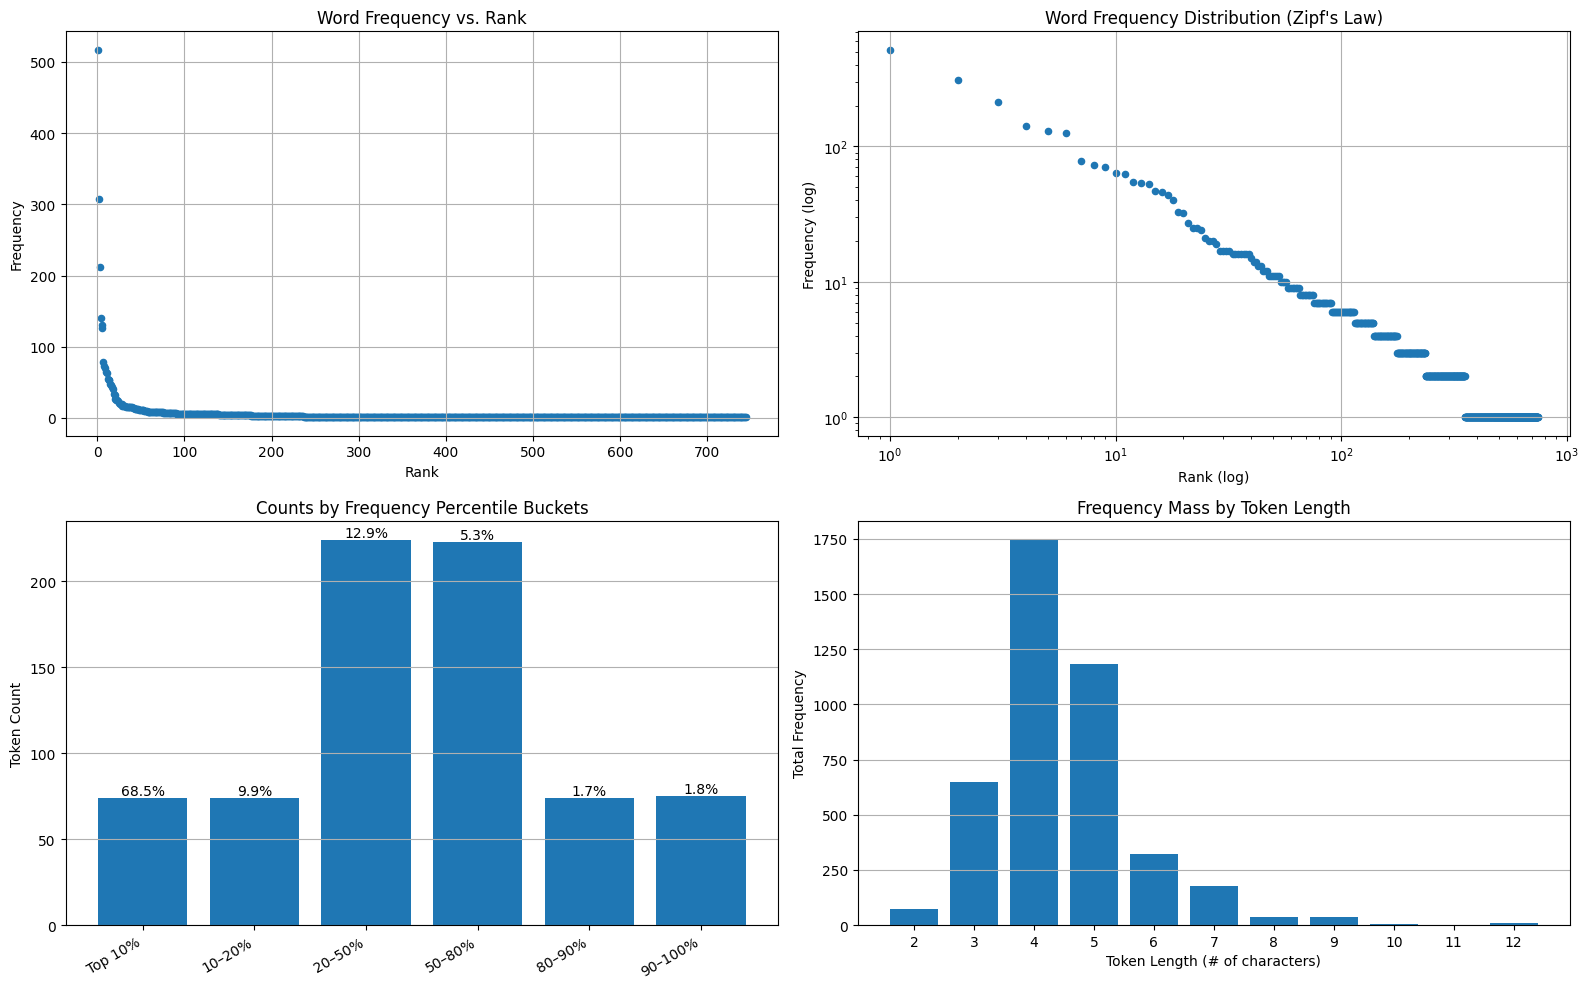

In [397]:
import numpy as np
import matplotlib.pyplot as plt

# Sort frequencies descending
freqs_sorted = np.array(sorted(lexicon.values(), reverse=True))
ranks = np.arange(1, len(freqs_sorted) + 1)

# -- precompute percentile buckets (by rank)
N = len(freqs_sorted)
pct_edges = [0, 10, 20, 50, 80, 90, 100]  # buckets: Top10, 10–20, 20–50, 50–80, 80–90, 90–100 (tail)
idx_edges = [int(np.floor(p/100 * N)) for p in pct_edges]
labels = [f"Top {pct_edges[1]}%"] + [f"{pct_edges[i]}–{pct_edges[i+1]}%" for i in range(1, len(pct_edges)-1)]

bucket_counts = []
bucket_mass_share = []
total_mass = freqs_sorted.sum()
for i in range(len(idx_edges)-1):
    lo, hi = idx_edges[i], idx_edges[i+1]
    cnt = max(hi - lo, 0)
    bucket_counts.append(cnt)
    mass = freqs_sorted[lo:hi].sum() if cnt > 0 else 0
    bucket_mass_share.append(100.0 * mass / total_mass if total_mass > 0 else 0.0)

# --- length histogram (1-char, 2-char, 3-char, ...) weighted by frequency
length_mass = {}
for token, c in lexicon.items():
    L = len(token)
    length_mass[L] = length_mass.get(L, 0) + c
lengths = np.array(sorted(length_mass.keys()))
length_counts = np.array([length_mass[L] for L in lengths])

# ---- 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) Simple scatter plot (rank vs frequency)
axes[0, 0].scatter(ranks, freqs_sorted, s=20)
axes[0, 0].set_xlabel("Rank")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Word Frequency vs. Rank")
axes[0, 0].grid(True)

# 2) Zipf's Law (log-log)
axes[0, 1].scatter(ranks, freqs_sorted, s=20)
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Rank (log)")
axes[0, 1].set_ylabel("Frequency (log)")
axes[0, 1].set_title("Word Frequency Distribution (Zipf's Law)")
axes[0, 1].grid(True)

# 3) Percentile bucket counts
x = np.arange(len(labels))
axes[1, 0].bar(x, bucket_counts)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, rotation=30, ha="right")
axes[1, 0].set_ylabel("Token Count")
axes[1, 0].set_title("Counts by Frequency Percentile Buckets")
axes[1, 0].grid(True, axis="y")
# annotate each bar with its mass share
for i, (xc, cnt, mass_pct) in enumerate(zip(x, bucket_counts, bucket_mass_share)):
    if cnt > 0:
        axes[1, 0].text(xc, cnt, f"{mass_pct:.1f}%", ha="center", va="bottom")

# 4) Length histogram (frequency-weighted)
axes[1, 1].bar(lengths, length_counts, width=0.8)
axes[1, 1].set_xticks(lengths)
axes[1, 1].set_xlabel("Token Length (# of characters)")
axes[1, 1].set_ylabel("Total Frequency")
axes[1, 1].set_title("Frequency Mass by Token Length")
axes[1, 1].grid(True, axis="y")

plt.tight_layout()
plt.show()


**Plots 1 & 2**

This might be an extreme case of Zipf's law, but the frequency of the word is strongly inversely related to its rank

Nonetheless, when reconstructing the words from the disjoint words, we'll ensure that we give more frequent words more weight, sort of a probabilistic approach. The priors being the frequency of the term in the lexicon relative to the other terms.

**Plot 3**

The top 10% most frequent tokens appear in 67.6% of the normalized corpus. Whereas the bottom 30% tokens appear in less than 10% of the corpus. To be cautious but also remove things that are less frequent, we'll remove the buttome 10% of tokens. 

In [398]:
# Just to be sure let's see some of those buttom 10%
items_sorted = sorted(lexicon.items(), key=lambda x: x[1])  
N = len(items_sorted)

# Bottom 10% by rank
pct = 10
cutoff_idx = min(int(np.ceil(pct / 100 * N)), 15)
bottom_10 = items_sorted[:cutoff_idx]

print(f"Bottom {pct}% tokens by rank (capped at 15 tokens):")
for token, freq in bottom_10:
    print(f"{token}: {freq}")

Bottom 10% tokens by rank (capped at 15 tokens):
مبسط: 1
جانبي: 1
برونزالفاء: 1
شريط: 1
اماراتي: 1
هان: 1
رويال: 1
حليبي: 1
سوبر: 1
سمارت: 1
كريمون: 1
موديل: 1
برنزالفاء: 1
سيليكون: 1
واكر: 1


The words appear to be meaningful, so we'll not drop any.

**Plot 4**
Most words fall within 3 and 7 characters. Let's see some examples of the extremes at 2 chars and 9 chars long:

In [399]:
print({k: v for k, v in lexicon.items() if len(k) == 2})

{'دن': 1, 'مع': 20, 'ضد': 1, 'لي': 1, 'من': 5, 'اي': 7, 'بن': 2, 'خط': 1, 'يا': 1, 'اب': 1, 'تر': 1, 'لم': 1, 'ال': 2, 'جي': 1, 'لو': 1, 'ام': 3, 'دي': 2, 'اف': 2, 'تي': 3, 'ما': 1, 'خا': 1, 'رش': 1, 'قص': 5, 'سن': 1, 'لا': 5, 'مت': 2}


In [400]:
{k: v for k, v in lexicon.items() if len(k) == 9}

{'برنزالفاء': 1,
 'الكهربائي': 1,
 'المواصفات': 2,
 'والمخططات': 1,
 'اكسسوارات': 8,
 'الخرسانيه': 17,
 'والقسامات': 1,
 'حديدتسليح': 4,
 'استتواريو': 1}

In [401]:
print(lexicon.get("حديد"))
print(lexicon.get("تسليح"))
print(lexicon.get("المخططات"))
print(lexicon.get("حديد"))
print(lexicon.get("حديد"))


517
308
None
517
517


## Combine disjointed letters
Combining the letters based on the lexicon is only one half of the solution, the other is to know what parts of the token we should look up in the lexicon and which parts should be omitted. 

### Research findings
This problem could be cut in three parts:
1. find unigram probability for each lexicon entry
2. create a Trie data structure from the lexicon
3. traverse the Trie and determine the word with most likelihood

### Trie and Viterbi Segment technique

In [ ]:
class TrieNode: # Node definition for the Trie
    __slots__ = ("ch","end","logp")
    def __init__(self):
        self.ch = {} # Child nodes dict
        self.end = False # Boolean: node marks a word's end
        self.logp = float("-inf") # Likelihood for this word, only relevant if end is True 

class Trie:
    def __init__(self):
        self.root = TrieNode()
    def insert(self, word, logp): # Insert a node in the Trie
        node = self.root
        for c in word:
            node = node.ch.setdefault(c, TrieNode()) # If there's a node for c return it, else create a new node for c
        node.end = True
        node.logp = logp
    def in_trie_prefix(self, s): # Checks if the string/word is in our Trie
        node = self.root
        for ch in s:
            if ch not in node.ch:
                return False
            node = node.ch[ch]
        return node.end

def build_trie_from_counts(counts, alpha=0.0):
    # counts: dict[word] -> int
    V = len(counts) # Vocabulary size
    Z = sum(counts.values()) + alpha * V # Denominator = N_train (total no. of words) + weighted V
    T = Trie()
    for w, c in counts.items():
        p = (c + alpha) / Z
        T.insert(w, log(p))
    return T

def viterbi_segment(chars, trie, del_char_logp=0):
    """chars: e.g. 'catsanddog' (spaces removed). Returns words and score."""
    if chars == "":
        return ""
    n = len(chars)
    best = [float("-inf")] * (n + 1)
    back = [None] * (n + 1) # (end of word: int, is word/skip: boolean)
    best[n] = 0.0  # empty suffix has score 0

    # This loop begins at the end of the sentence, to evaluate all possible word formations taking into account the entire sentence
    for i in range(n - 1, -1, -1): 
        node = trie.root
        j = i
        while j < n and chars[j] in node.ch: # Check if the char exists in the children of the current node
            node = node.ch[chars[j]] # Look at the branch associated with chars[j]
            j += 1
            if node.end: # If chars[i:j] completes a word, then step in
                cand = node.logp + best[j] # The core of the Viterbi DP; considers likelihood of chars[i:j] and even chars[j:] 
                if cand > best[i]:
                    best[i] = cand
                    back[i] = (j, True)
        
        # Mark char position as a skip when it doesn't form a word and propagate logp
        # this helps when the end of the sentence isn't found in lexicon/Trie:
        if best[i] == float("-inf"):
             best[i] = best[i + 1] + del_char_logp # Propogate the word likelihood continuation
             back[i]=(i+1, False)

    # Reconstruct the words
    words = []
    i = 0
    while i < n:
        j, is_word = back[i]
        if is_word: # i.e. character at i isn't marked as skip
            words.append(chars[i:j])
        i = j

    # In case we failed to construct any words
    if not words:
        return "Unknown", 1

    return words, best[0]

Notes:
- Choosing whether to penalize the skipping of a character or not was a tricky task. On one hand, when we don't penalize we give more weight to finding the most frequent words in the sentence. On the other, when we do penalize we persuade the algorithm out of dismantaling the already formed words.
    - Actually it is intresting to understand how the penalty affects the decsion; we are considering the whole path of characters. If we already decided at j+1 a word exists, the penality drags any further scores further down such that they are always < best[j+1]
    - Decided to favor more frequent words over first seen words in sentence

#### A few tests
Now we can find reconstruct the disjointed words in the Item Name column

In [403]:
# Toy example
counts = {
    "cat": 50, "cats": 30, "sand": 25, "and": 100, "an": 550, "dog": 70
}
trie = build_trie_from_counts(counts, alpha=1.0)
words, score = viterbi_segment("catsanddog", trie)
print(words)  # e.g., ['cats', 'and', 'dog'] 


['cats', 'an', 'dog']


We purposfully choose to find `an` in the sentence above. Although `and` is the right choice, we can't be certain of which word is right all the time unless we resort to an LLM or another expensive technique. Hence, choosing based on frequency is a sufficient heuristic.

In [404]:
# Example from our data

trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[1563], trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج', 'اسود', 'لم'] -15.046996534600053


In [405]:
trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[2833], trie_ar)
print(df["Disjointed"].iloc[2833])
print(words, score)

حديدمجدولاتفاقملممترسعود
['حديد', 'مجدول', 'اتفاق', 'لم', 'مت'] -26.442175134707554


##### More tests - ignore

In [406]:
print("لم in trie?", trie_ar.in_trie_prefix("لم"))

لم in trie? True


In [407]:
print("مجدول in trie?", trie_ar.in_trie_prefix("مجدول"))

مجدول in trie? True


In [408]:
words, score = viterbi_segment("صاج", trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج'] -3.669198866614692


In [409]:
chars = "صاجاسودملمت"
counts = {"صاج" : 1, "اسود" :1, "ملمت" : 1}

trie = build_trie_from_counts(lexicon)
seg, score = viterbi_segment(chars, trie_ar)

print(seg, score)

['صاج', 'اسود', 'لم'] -15.046996534600053


In [410]:
print("صاج in trie?", trie_ar.in_trie_prefix("صاج"))

صاج in trie? True


### Rejoining the disjointed words

In [411]:
def segment_and_join(text, trie):

    words, score = viterbi_segment(text, trie)

    if words is None:
        # Segmentation failed → just return original text
        return text
    # Join words with spaces
    return " ".join(words)

In [412]:
df["Rejoined"] = df["Disjointed"].apply(lambda t: segment_and_join(t, trie_ar))

In [ ]:
# Let's see the results
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed,Rejoined
301,فرشة سرايا 6.5 مم PB7 برونزالفاء (PCS),فرشه سرايا PB برونزالفاء PCS,,U n k n o w n
901,GATE BARIAR PANEL2,GATE BARIAR PANEL,,U n k n o w n
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود لم


In [414]:
df["Rejoined"].iloc[2833]

'حديد مجدول اتفاق لم مت'

In [415]:
# Now let's add a new fully preprocessed column


## Analyze tokens

## Reduced tokens

## Numerical tokens

# Train classifier

# Appendix

## Tests

### Trying out normlization techniques

In [416]:
text = "ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ"
text

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [417]:
# This does a good job in standardizing the characters
import unicodedata
result = unicodedata.normalize("NFKC", text)
result

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [418]:
import re
result = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', text)
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [419]:
result = re.sub(r'\s+', ' ', text).strip()
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

None of the techniques above effictively resolves the issue of spaces and word recognition in text...

We'll try out Camel-tools, I've had a little experience with it before, but never worked with data this messy

In [420]:
import camel_tools.utils.normalize as norm

In [421]:
norm.normalize_unicode(text)

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [422]:
from camel_tools.utils.dediac import dediac_ar
dediac_ar(norm.normalize_unicode(text))

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [423]:
# Oh they're well indexed
chars = "سلام"
print(chars[0], chars[1])

س ل


In [424]:
# What about this
for i in range(len(chars)- 1, -1, -1): 
    print(chars[i])

م
ا
ل
س


In [ ]:
mle = MLEDisambiguator.pretrained('calima-msa-r13')

clean = " " #"تیوبفارغمربع 80 × 80 × 5 مل 6 متر"

# 3) whitespace/punct tokenization (required by CAMeL’s morph tokenizer)
words = simple_word_tokenize(normalize_mixed_arabic(clean))

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='atbtok', split=True)
segmented = mtok.tokenize(words)
segmented

### Failed attempts by ChatGPT that took far too much time to test and had minimal improvements

In [425]:
import re
from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar

# Unicode ranges that cover Arabic letters (not presentation forms)
_AR = r'\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF'

def normalize_mixed_arabic(s: str) -> str:
    # 1) Canonical/compatibility normalization
    s = normalize_unicode(s, compatibility=True)
    # 2) Normalize alef maqsura, optional but useful
    s = normalize_alef_maksura_ar(s)

    # 3) Strip zero-width/bidi formatting chars
    s = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', s)

    # 4) Normalize common operators and pad them
    #    Treat *, ×, x as multiplication; surround with single spaces
    s = re.sub(r'\s*([*xX×])\s*', r' × ', s)

    # 5) **Key step**: remove spaces *only* between Arabic letters
    #    This stitches scattered letters back into words
    s = re.sub(fr'(?<=[{_AR}])\s+(?=[{_AR}])', '', s)

    # 6) Collapse remaining excessive whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

# Demo on your string
sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(normalize_mixed_arabic(sample))


تیوبفارغمربع 80 × 80 × 5 مل 6 متر


In [426]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

# 1) choose a pretrained analyzer/disambiguator (MSA shown)
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# 2) after your intra-letter stitching + spacing heuristics:
clean = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"#"تیوبفارغمربع 80 × 80 × 5 مل 6 متر"

# 3) whitespace/punct tokenization (required by CAMeL’s morph tokenizer)
words = simple_word_tokenize(normalize_mixed_arabic(clean))

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='atbtok', split=True)
segmented = mtok.tokenize(words)
segmented

['تیوبفارغمربع', '80', '×', '80', '×', '5', 'مل', '6', 'متر']

In [427]:
import re
import unicodedata
from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar     # ة -> ه or keep ة depending on needs
)
from camel_tools.utils.dediac import dediac_ar

# Arabic block after NFKC
ARABIC_RANGE = r"\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF"
AR_LETTER = f"[{ARABIC_RANGE}]"
DIGIT = r"[0-9\u0660-\u0669]"  # Western + Arabic-Indic

def to_ascii_digits(s: str) -> str:
    # map Arabic-Indic digits to ASCII
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")
    return s.translate(trans)

def normalize_ar_text(s: str, keep_diacritics=False):
    # 1) collapse presentation forms, compatibility, widths, etc.
    s = unicodedata.normalize("NFKC", s)

    # 2) remove tatweel and bidi/formatting chars
    s = s.replace("\u0640", "")  # tatweel
    s = re.sub(r"[\u200c\u200d\u200e\u200f\u061c]", "", s)  # ZWNJ/ZWJ/LRM/RLM/ALM

    # 3) unify common Arabic variants
    s = normalize_alef_ar(s)
    s = normalize_alef_maksura_ar(s)
    s = normalize_teh_marbuta_ar(s)

    # 4) optional: strip diacritics (recommended for noisy sources)
    if not keep_diacritics:
        s = dediac_ar(s)

    # 5) digits to ASCII for easier heuristics
    s = to_ascii_digits(s)

    return s

def fix_spaced_glyphs(s: str):
    s = normalize_ar_text(s)

    # --- spacing repair heuristics ---

    # A) collapse spaces inserted between Arabic letters (re-form words)
    # remove spaces when both sides are Arabic letters
    s = re.sub(fr"(?<={AR_LETTER})\s+(?={AR_LETTER})", "", s)

    # B) ensure spaces around math operators and 'x'
    s = re.sub(r"\s*([*+\-/x×])\s*", r" \1 ", s)

    # C) split between letters and digits (both directions)
    s = re.sub(fr"(?<={AR_LETTER})(?={DIGIT})", " ", s)
    s = re.sub(fr"(?<={DIGIT})(?={AR_LETTER})", " ", s)

    # D) heuristic: insert a space when a right-joining (non-connecting-left) letter
    # is followed by another letter (helps recover word boundaries)
    non_joiners = "ادذرزوةى"  # letters that do not connect to the following letter
    s = re.sub(fr"(?<=[{non_joiners}])(?={AR_LETTER})", " ", s)

    # E) normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(fix_spaced_glyphs(sample))


تیو بفا ر غمر بع 80 * 80 * 5 مل 6 متر
